In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import matplotlib.cm as cm
from tensorflow.python.framework import ops
import math
from random import randint
%matplotlib inline

In [2]:
def dense_to_one_hot(indices, depth):
    depth1 = tf.constant(depth, dtype=tf.int32)
    one_hot_matrix = tf.one_hot(indices, depth1, axis=0)
    one_hot = sess.run(one_hot_matrix)
    return one_hot

In [3]:
def random_mini_batches(X, Y, mini_batch_size=128, seed = 0):
    m = X.shape[1]
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((10,m))
    
    num_complete_minibatches = int(math.floor(m/mini_batch_size))
    
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0 :
        mini_batch_X = shuffled_X[:, (k+1)*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, (k+1)*mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [4]:
def create_placeholders(nx, ny):
    X = tf.placeholder(dtype=tf.float32, shape=(nx, None))
    Y = tf.placeholder(dtype=tf.float32, shape=(ny, None))
    keep_prob = tf.placeholder(dtype=tf.float32)
    return X, Y, keep_prob

In [5]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [50,784], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b1 = tf.get_variable("b1", [50,1], initializer=tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", [25,50], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b2 = tf.get_variable("b2", [25,1], initializer=tf.zeros_initializer())
    
    W3 = tf.get_variable("W3", [10,25], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b3 = tf.get_variable("b3", [10,1], initializer=tf.zeros_initializer())
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2, "W3":W3, "b3":b3}
    return parameters

In [6]:
def forward_propogation(X, parameters, keep_prob):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    Z1_drop = tf.nn.dropout(Z1, keep_prob)
    A1 = tf.nn.relu(Z1_drop)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    Z2_drop = tf.nn.dropout(Z2, keep_prob)
    A2 = tf.nn.relu(Z2_drop)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    Z3_drop = tf.nn.dropout(Z3, keep_prob)
    
    return Z3_drop
    

In [22]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    return cost

In [16]:
def model(Xtrain, Ytrain, Xtest, Ytest, learning_rate=0.0001, num_epochs=200, mini_batch_size=32,keep_prob=0.5):
    ops.reset_default_graph()
    seed=1
    (nx, m) = Xtrain.shape
    ny = Ytrain.shape[0]
    costs = []
    
    X, Y, keep_prob_ph = create_placeholders(nx, ny)
    parameters = initialize_parameters()
    Z3 = forward_propogation(X, parameters, keep_prob_ph)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(0, num_epochs+1):
            epoch_cost=0.
            num_mini_batches = int(m/mini_batch_size)
            seed = seed+1
            minibatches = random_mini_batches(Xtrain, Ytrain, mini_batch_size, seed)
            
            for minibatch in minibatches:
                (mini_batch_X, mini_batch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={
                    X : mini_batch_X, 
                    Y : mini_batch_Y, 
                    keep_prob_ph : keep_prob })
                epoch_cost+=minibatch_cost/num_mini_batches
            
            if epoch%10==0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                costs.append(epoch_cost)
                
        if epoch%10!=0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title('learning rate = ', str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        
        correct_prediction = tf.equal(tf.argmax(Z3,1), tf.argmax(Y,1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print 'Train Accuracy:', accuracy.eval({X:Xtrain, Y:Ytrain, keep_prob_ph:1})
        print 'Test Accuracy:', accuracy.eval({X:Xtest, Y:Ytest, keep_prob_ph:1})
        
        return parameters
        

In [17]:
def predict(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
        
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [784, None])
    z3 = forward_propagation(x, params, 1)
    p = tf.argmax(z3)
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
    return prediction

In [18]:
def write_predictions(predictions):
    with open('./submission_nn_tf.csv', 'w') as subs:
        subs.write("ImageId,Label\n")
        for i, pred in enumerate(predictions):
            subs.write(str(i+1)+','+str(pred)+'\n')

(784, 40000) (784, 2000)


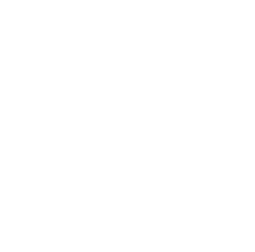

In [13]:
totalTrain = 42000
tainPart = 40000
testPart = 2000
data = []
sess = tf.Session()
with open('./train.csv', 'r') as train:
    pixelReader = csv.reader(train, delimiter=',')
    next(pixelReader, None)
    for row in pixelReader:
        data.append(row[0:])
        
data = np.array(data).astype(int)
np.random.shuffle(data)
data_train, data_test = data[:tainPart,:], data[tainPart:,:]
labels_train_dense = data_train[:, 0]
labels_test_dense = data_test[:, 0]

data_train = np.multiply(data_train[:, 1:].T, 1/255)
data_test = np.multiply(data_test[:, 1:].T, 1/255)
assert(data_train.shape == (784, tainPart))
assert(data_test.shape == (784, testPart))

labels_train = dense_to_one_hot(labels_train_dense, 10)
labels_test = dense_to_one_hot(labels_test_dense, 10)
assert(labels_train.shape == (10, tainPart))
assert(labels_test.shape == (10, testPart))

image_to_show = 100
plt.axis('off')
plt.imshow(data_train[:, image_to_show].reshape(28, 28),  cmap=cm.binary)
sess.close()

#read test data
test = []
with open('./test.csv', 'r') as train:
    pixelReader = csv.reader(train, delimiter=',')
    next(pixelReader, None)
    for row in pixelReader:
        test.append(row[0:])

test = np.array(test).astype(int)
test = np.multiply(test, 1.0 / 255.0)
test = test.T
print data_train.shape, data_test.shape

In [23]:
parameters = model(data_train, labels_train, data_test, labels_test, 
                   learning_rate = 0.001, num_epochs = 750, keep_prob=0.99, mini_batch_size = 64)

Cost after epoch 0: 26.620950
Cost after epoch 10: 26.929658
Cost after epoch 20: 27.357429


KeyboardInterrupt: 